# Introdução

##Evolução do número de leitos no estado de Goiás durante a pandemia COVID-19

Manter e gerar um número suficiente de leitos para atender pacientes vítimas da COVID-19 é um desafio constante para os estados brasileiros. A pandemia trouxe consigo uma série de problemas, incluindo aumento no número de casos e hospitalizações, além da necessidade de adaptação rápida das estruturas de saúde.

A análise exploratória que será feita sobre a evolução do número de leitos no estado de Goiás durante a pandemia tem como objetivo entender como esses desafios foram enfrentados e se as medidas tomadas foram eficientes para garantir todo o suporte necessário aos pacientes, e se as medidas foram implementadas de forma homogênea entre os municípios do estado. Através da utilização de dados geográficos e estatísticos, espera-se ter uma visão mais clara sobre a eficácia das ações implementadas.

# Coleta de dados

<p align="center">
  <img src="https://www.insper.edu.br/wp-content/uploads/2020/07/datasus.png">
</p>

O DataSUS (Dados em Saúde do Sistema Único de Saúde) é um sistema de informação do Ministério da Saúde que tem como objetivo reunir, armazenar e disponibilizar dados sobre a saúde no Brasil. Esses dados são coletados de diversas fontes, como hospitais, unidades básicas de saúde e outros estabelecimentos de saúde.

o DataSUS foi de extrema importância durante a pandemia de COVID-19, pois permitiu acesso a dados oficiais e confiáveis sobre a evolução da doença no país. Através dele foi possível obter informações como o número de casos confirmados, de óbitos e de leitos disponíveis para tratamento de pacientes com COVID-19 em cada estado e município brasileiro. Esses dados foram, e ainda são, fundamentais para o planejamento e a tomada de decisão dos órgãos responsáveis pela saúde pública no combate à pandemia.

O CNES (Cadastro Nacional de Estabelecimentos de Saúde) é um subsistema do DataSUS que tem como objetivo registrar informações sobre os estabelecimentos de saúde no país, como endereço, tipo de estabelecimento, número de leitos, entre outras informações. Essas informações são utilizadas pelo Ministério da Saúde para planejamento e gestão da saúde no país.

<p align="center">
<img src="https://www.cnm.org.br/cms/images/stories/comunicacao_novo/saude/24012020_CNES.jpg" width="400" height="300">
</p>

Para facilitar a extração de dados do CNES foi utilizado o Pysus, um pacote desenvolvido em Python que permite acesso e manipulação dos dados do DataSUS de forma simplificada. Ele é uma ótima opção para aqueles que desejam realizar análises de dados de saúde no Brasil utilizando a linguagem Python.

Para analisar a evolução do número de leitos nos municípios de Goiás durante a pandemia, foram extraídos dados do CNES através do Pysus.


In [1]:
!pip install -q pysus
!pip install -q geopandas
# !pip install -q geoplot

In [11]:
import pandas as pd
import numpy as np
import pysus
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager
import geopandas as gpd
import folium
import folium.plugins as plugins
import seaborn as sns
import math

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [6]:
from pysus.online_data.CNES import download

for ano in [2019, 2020, 2021, 2022]:
  for mes in range(1,12,1):
    if (ano == 2019) & (mes == 1):
      df = download(group = 'LT', state = 'GO', year = ano, month = mes, cache = False)
    else:
      df = pd.concat([df, download(group = 'LT', state = 'GO', year = ano, month = mes, cache = False)])

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df.to_parquet('/content/drive/MyDrive/repos/Analise_Leitos_Goias/Dados/dados_leitos_goias.parquet')

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/repos/Analise_Leitos_Goias/Dados/dados_leitos_goias.parquet')
df.head()

,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR
0,9331603,520010,,,,,M,3,00000000000000,3,01298330000178,,04,,,03,15,06,,,2,33,9,0,9,0,201901,1244
1,2335506,520013,15,,,,M,3,00269860000125,1,00000000000000,,04,,,03,05,06,,,4,10,1,0,1,0,201901,2062
2,2335506,520013,15,,,,M,3,00269860000125,1,00000000000000,,04,,,03,05,06,,,2,41,2,0,2,0,201901,2062
3,2335506,520013,15,,,,M,3,00269860000125,1,00000000000000,,04,,,03,05,06,,,4,43,3,0,3,0,201901,2062
4,2335506,520013,15,,,,M,3,00269860000125,1,00000000000000,,04,,,03,05,06,,,6,34,4,0,3,1,201901,2062


## Dicionário de colunas

A seguir está o dicionário de colunas documentado e disponibilizado em PDF no DataSUS


* `CNES` -	Número nacional do estabelecimento de saúde
* `CODUFMUN` -	Código do município do estabelecimento UF+ MUNIC (sem dígito)
* `REGSAUDE` -	Código da região de saúde
* `MICR_REG` -	Código da micro-região de saúde
* `DISTRSAN` -	Código do distrito sanitário
* `TPGESTAO` -	Gestão de saúde
* `PF_PJ` -	Indicador de pessoa: 1-Física 3-Jurídica
* `CPF_CNPJ` -	CPF do Estabelecimento, caso pessoa física OU CNPJ, caso pessoa jurídica
* `NIV_DEP` -	Grau de dependência: 1-Individual 3-Mantida
* `CNPJ_MAN` -	CNPJ da mantenedora do Estabelecimento
* `ESFERA_A` -	Código da esfera administrativa
* `ATIVIDAD` -	Código da atividade de ensino
* `RETENCAO` -	Código de retenção de tributos
* `NATUREZA` -	Código da natureza da organização
* `CLIENTEL` -	Código de fluxo da clientela
* `TP_UNID` -	Tipo de unidade (Estabelecimento)
* `TURNO_AT` -	Código de turno de atendimento
* `NIV_HIER` -	Código do nível de hierarquia
* `TERCEIRO` -	O estabelecimento é terceiro: 1-Sim 0-Não
* `TP_LEITO` -	Tipo do LEITO
* `CODLEITO` -	Especialidade do LEITO
* `QT_EXIST` -	Quantidade de leitos existentes
* `QT_CONTR` -	Quantidade de leitos contratados
* `QT_SUS` -	Quantidade de leitos para o SUS
* `COMPETEN` -	Ano e Mês de competência da informação (AAAAMM)

Para enriquecer a análise exploratória foram extraídos dados geográficos dos municípios de Goiás fornecidos pelo Instituto Brasileiro de Geografia e Estatística (IBGE). Esses dados incluem informações como as coordenadas geográficas, limites territoriais e códigos dos municípios. Essas informações são fundamentais para a análise geográfica de dados, permitindo a visualização e análise espacial dos dados. Essas informações serão valiosas para entender a evolução da distribuíção geográfica do número de leitos por município no estado de Goiás durante a pandemia.

Foi utilizada a biblioteca Geopandas para a leitura do arquivo *shapefile* com os dados geográficos dos municípios de Goiás, bem como fazer as devidas conversões dos dados para se obter as informações de longitude e latitude de cada município.

In [16]:
df_geo = gpd.read_file('/content/drive/MyDrive/repos/Analise_Leitos_Goias/Dados/GO_Municipios_2021/GO_Municipios_2021.shp')
df_geo.head()

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry
0,5200050,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7..."
1,5200100,Abadiânia,GO,1044.555,"POLYGON ((-48.79129 -16.01593, -48.79122 -16.0..."
2,5200134,Acreúna,GO,1566.742,"POLYGON ((-50.39203 -17.18881, -50.35417 -17.3..."
3,5200159,Adelândia,GO,115.385,"POLYGON ((-50.19642 -16.30048, -50.19597 -16.3..."
4,5200175,Água Fria de Goiás,GO,2023.636,"POLYGON ((-47.76054 -14.63915, -47.75952 -14.6..."


In [6]:
# Lê os dados do Brasil.IO
df_covid = pd.read_csv('/content/drive/MyDrive/repos/Analise_Leitos_Goias/Dados/casos_covid.csv')
df_covid.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0


#Análise Exploratória

## Limpeza e preparação dos dados

In [17]:
#cria coluna tipo datetime
df['data'] = pd.to_datetime(df['COMPETEN'], format='%Y%m')

#cria dataframe para total de leitos por município em todo o período
leitos_municipios = df.groupby(['CODUFMUN','data']).aggregate({'QT_EXIST':'sum', 'QT_SUS': 'sum', 'QT_NSUS': 'sum'}).reset_index()

#cria dataframe com total de leitos antes da pandemia
leitos_municipios_pre = leitos_municipios.sort_values(by = 'data').drop_duplicates('CODUFMUN').reset_index()

#cria dataframe com total de leitos pós pandemia
leitos_municipios_pos = leitos_municipios.sort_values(by = 'data', ascending = False).drop_duplicates('CODUFMUN').reset_index()

In [8]:
#filtro para todo o estado de goiás
df_covid_goias = df_covid[(df_covid.state == 'GO') & (df_covid.city.isnull())].sort_values(by = 'date')

#agrupando por mês e ano
df_covid_goias['date'] = pd.to_datetime(df_covid_goias['date'])

# Criar nova coluna com mês e ano
df_covid_goias['mes_ano'] = df_covid_goias['date'].dt.to_period('M')
#agrupando dados
df_covid_goias = df_covid_goias.groupby('mes_ano').aggregate({'date':'max', 'new_confirmed': 'sum', 'new_deaths': 'sum'}).reset_index()

df_covid_municipios = df_covid[(df_covid.state == 'GO') & (df_covid.city.notnull())].sort_values(by = 'date')
df_covid_municipios = df_covid_municipios.rename(columns = {'city':'NM_MUN'})


In [18]:
#remove dígito do código de municípios
df_geo['CD_MUN'] = df_geo['CD_MUN'].str[:-1]

#definindo longitude e latitude
df_geo['x'] = df_geo['geometry'].representative_point().x
df_geo['y'] = df_geo['geometry'].representative_point().y

#agregando informações de população para criação de coluna que representa densidade populacional
df_geo_new = pd.merge(df_geo, df_covid_municipios[['NM_MUN', 'estimated_population_2019']], how = 'left', on = 'NM_MUN')
df_geo_new['população_por_km2'] = df_geo_new['estimated_population_2019'] / df_geo_new['AREA_KM2']

#joining dataframes
df_geo_new = df_geo_new.rename(columns = {'CD_MUN':'CODUFMUN'})
leitos_municipios_pre = pd.merge(df_geo_new, leitos_municipios_pre[['CODUFMUN', 'QT_EXIST']], how = 'left', on = 'CODUFMUN')
leitos_municipios_pos = pd.merge(df_geo_new, leitos_municipios_pos[['CODUFMUN', 'QT_EXIST']], how = 'left', on = 'CODUFMUN')

In [14]:
leitos_municipios_pre.head()

,CODUFMUN,NM_MUN,SIGLA,AREA_KM2,geometry,x,y,estimated_population_2019,população_por_km2,QT_EXIST
0,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
1,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
2,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
3,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
4,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN


In [15]:
leitos_municipios_pos.head()

,CODUFMUN,NM_MUN,SIGLA,AREA_KM2,geometry,x,y,estimated_population_2019,população_por_km2,QT_EXIST
0,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
1,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
2,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
3,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN
4,520005,Abadia de Goiás,GO,143.357,"POLYGON ((-49.43605 -16.72057, -49.43589 -16.7...",-49.454403,-16.791128,8773.0,61.196872,NaN


# Avaliação da capacidade hospitalar por município

## Distribuição geográfica de leitos

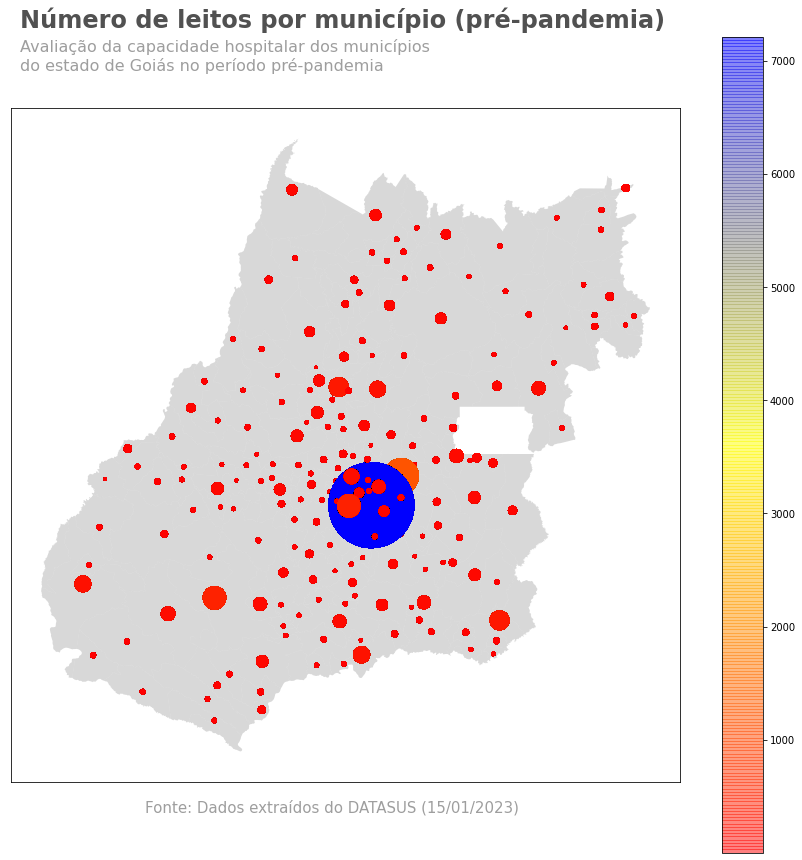

In [39]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

fig, ax = plt.subplots(figsize=(15,15))
df_geo.plot(ax=ax, color="grey", alpha=0.3)


# Criação da escala de cores personalizada
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'yellow', 'blue'], N=256)

# criando o heatmap pré pandemia

sc = ax.scatter(leitos_municipios_pre['x'] , leitos_municipios_pre['y'], s=leitos_municipios_pre['QT_EXIST'], c = leitos_municipios_pre['QT_EXIST'], cmap=cmap, alpha=0.5)
plt.colorbar(sc)

# remover yticks e yticklabels
ax.set_xticklabels(labels=[], visible=False)
ax.set_xticks(ticks=[])
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])

# title
ax.text(-53.5, -11.1,'Número de leitos por município (pré-pandemia)', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-53.5, -11.6,'Avaliação da capacidade hospitalar dos municípios \ndo estado de Goiás no período pré-pandemia', fontsize=16, color=CINZA)

# rodapé
ax.text(
    -52,
    -20.2,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    )

# exibindo o gráfico
plt.show()

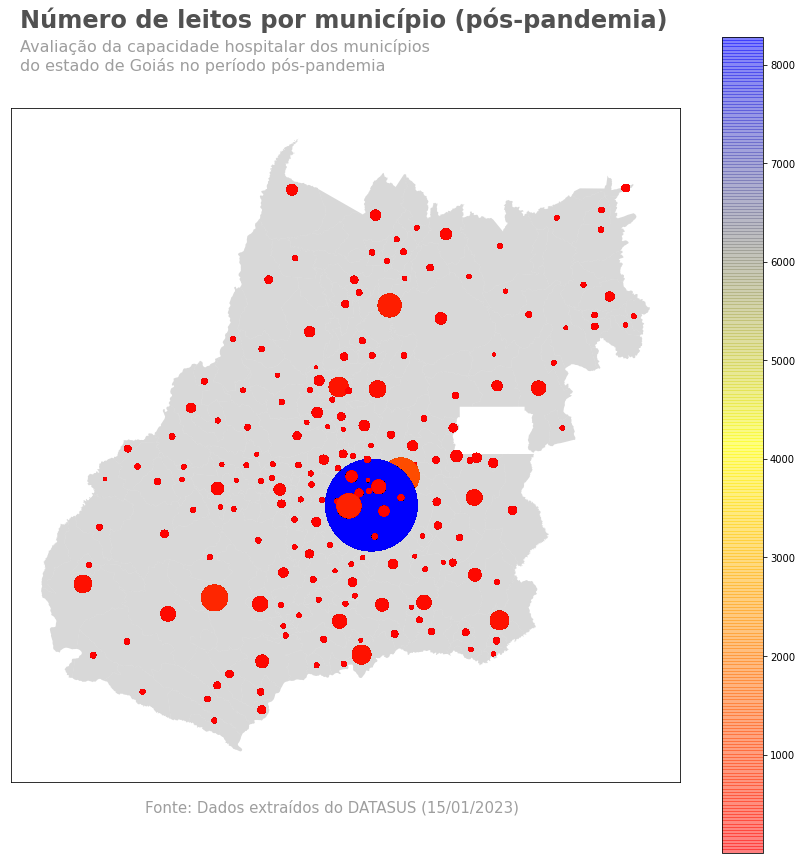

In [40]:
print("\n\n\n\n")

fig, ax = plt.subplots(figsize=(15,15))

df_geo.plot(ax=ax, color="grey", alpha=0.3)

# Criação da escala de cores personalizada
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'yellow', 'blue'], N=256)

# criando o heatmap pré pandemia

sc = ax.scatter(leitos_municipios_pos['x'] , leitos_municipios_pos['y'], s=leitos_municipios_pos['QT_EXIST'], c = leitos_municipios_pos['QT_EXIST'], cmap=cmap, alpha=0.5)
plt.colorbar(sc)

# remover yticks e yticklabels
ax.set_xticklabels(labels=[], visible=False)
ax.set_xticks(ticks=[])
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])

# title
ax.text(-53.5, -11.1,'Número de leitos por município (pós-pandemia)', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-53.5, -11.6,'Avaliação da capacidade hospitalar dos municípios \ndo estado de Goiás no período pós-pandemia', fontsize=16, color=CINZA)

# rodapé
ax.text(
    -52,
    -20.2,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    )

# exibindo o gráfico
plt.show()

Observa-se que na região central de Goiás é onde existe a maior concentração de leitos, porém isso não significa maior capacidade hospitalar nesta região, pois é preciso levar em conta que municípios de grande população e extensão territorial naturalmente possuem um número maior de leitos hospitalares.

## Distribuição geográfica da capacidade hospitalar

Nesta análise estou considerando capacidade hospitalar como:

`Capacidade hospitalar` = `Total de leitos` / `densidade populacional`

sendo:

`densidade populacional` = `população do município` / `extensão territorial`


Desta forma pode observar de forma mais justa e qualitativamente quais municípios tem melhor capacidade de dar tratamento de saúde, levando em conta não só o número de leitos existentes, mas também a concentração de pessoas.

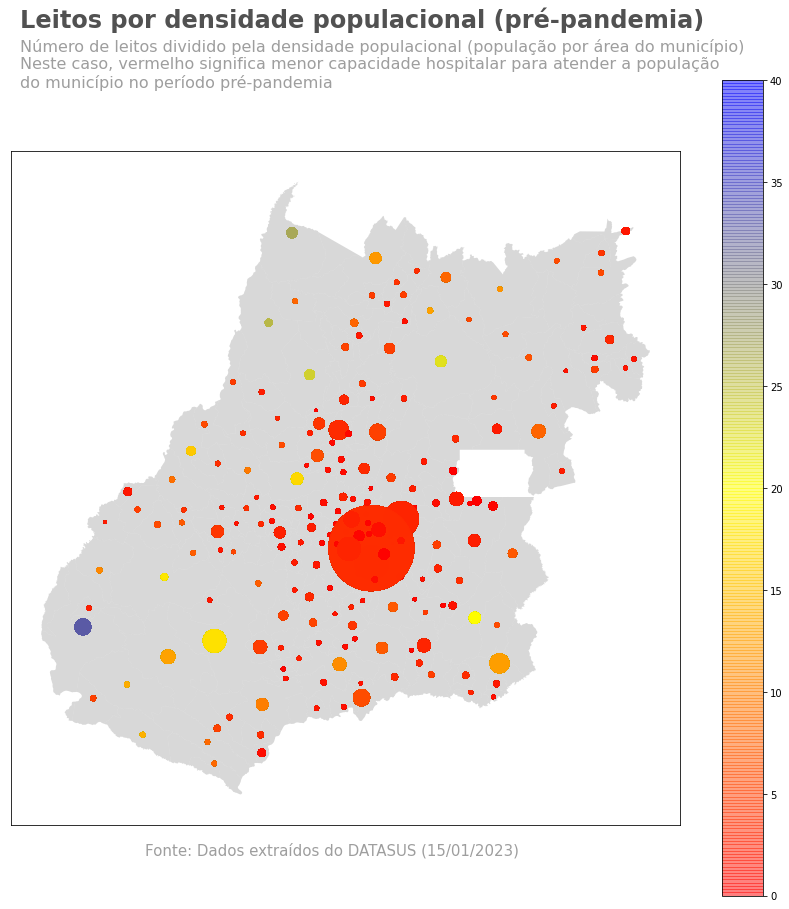

In [35]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

fig, ax = plt.subplots(figsize=(15,15))
df_geo.plot(ax=ax, color="grey", alpha=0.3)


# Criação da escala de cores personalizada
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'yellow', 'blue'], N=256)

# Definição dos limites de escala de cores
norm = plt.Normalize(vmin=0, vmax=40)

# criando o heatmap pré pandemia
leitos_municipios_pre['leitos_por_populaçãokm2'] = leitos_municipios_pre['QT_EXIST'] / leitos_municipios_pre['população_por_km2']

sc = ax.scatter(leitos_municipios_pre['x'] , leitos_municipios_pre['y'], s=leitos_municipios_pre['QT_EXIST'], c = leitos_municipios_pre['leitos_por_populaçãokm2'], cmap=cmap, alpha=0.5, norm = norm)
plt.colorbar(sc)

# remover yticks e yticklabels
ax.set_xticklabels(labels=[], visible=False)
ax.set_xticks(ticks=[])
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])

# title
ax.text(-53.5, -10.6,'Leitos por densidade populacional (pré-pandemia)', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-53.5, -11.3,'Número de leitos dividido pela densidade populacional (população por área do município)\nNeste caso, vermelho significa menor capacidade hospitalar para atender a população\ndo município no período pré-pandemia', fontsize=16, color=CINZA)

# rodapé
ax.text(
    -52,
    -20.2,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    )

# exibindo o gráfico
plt.show()

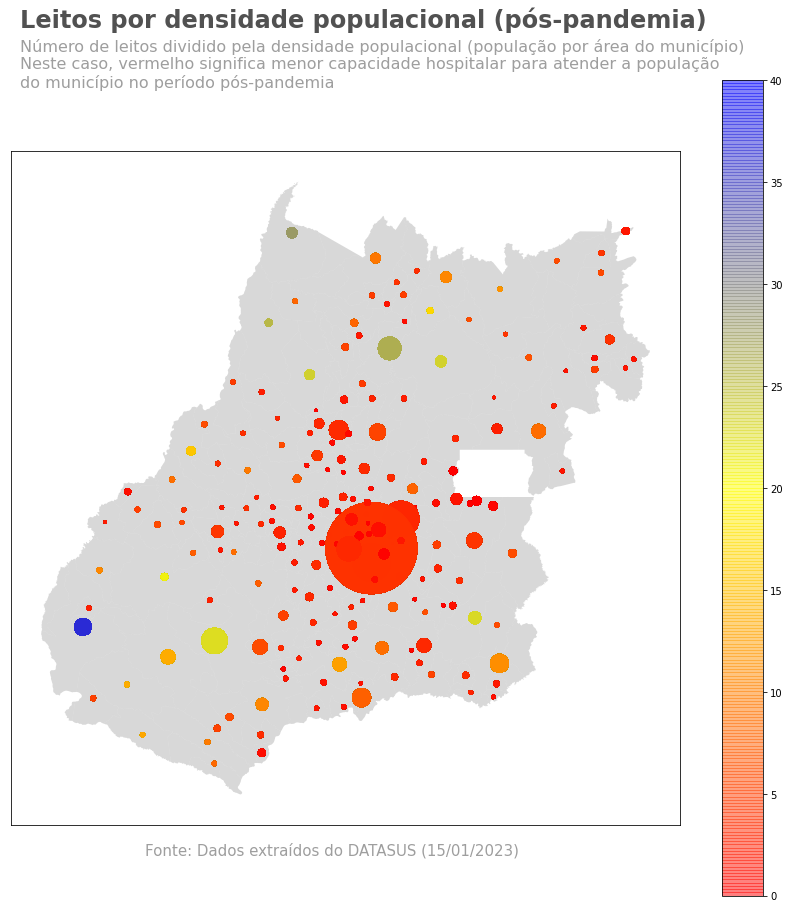

In [36]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

fig, ax = plt.subplots(figsize=(15,15))
df_geo.plot(ax=ax, color="grey", alpha=0.3)


# Criação da escala de cores personalizada
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'yellow', 'blue'], N=256)

# Definição dos limites de escala de cores
norm = plt.Normalize(vmin=0, vmax=40)

# criando o heatmap pré pandemia
leitos_municipios_pos['leitos_por_populaçãokm2'] = leitos_municipios_pos['QT_EXIST'] / leitos_municipios_pos['população_por_km2']

sc = ax.scatter(leitos_municipios_pos['x'] , leitos_municipios_pos['y'], s=leitos_municipios_pos['QT_EXIST'], c = leitos_municipios_pos['leitos_por_populaçãokm2'], cmap=cmap, alpha=0.5, norm = norm)
plt.colorbar(sc)

# remover yticks e yticklabels
ax.set_xticklabels(labels=[], visible=False)
ax.set_xticks(ticks=[])
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])

# title
ax.text(-53.5, -10.6,'Leitos por densidade populacional (pós-pandemia)', fontsize=24, color=CINZA_TEXTO, fontweight='bold')
ax.text(-53.5, -11.3,'Número de leitos dividido pela densidade populacional (população por área do município)\nNeste caso, vermelho significa menor capacidade hospitalar para atender a população\ndo município no período pós-pandemia', fontsize=16, color=CINZA)

# rodapé
ax.text(
    -52,
    -20.2,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    )

# exibindo o gráfico
plt.show()

Em ambos os mapas pode-se observar que os municípios que apresentaram maior número de leitos na verdade são os que apresentam a menor relação de número de leitos por densidade populacional, e por isso é correto afirmar que esses municípios possuem menor capacidade hospitalar.

É possível observar uma melhora na capacidade hospitalar dos municípios ao comparar os mapas pré-pandemia e pós-pandemia.

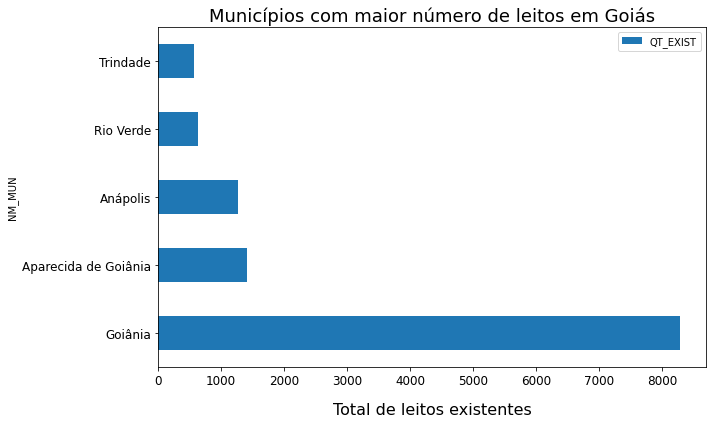

In [44]:
data_top5 = leitos_municipios_pos.sort_values(by = 'QT_EXIST', ascending = False).drop_duplicates('NM_MUN')[:5]

fix, ax = plt.subplots(figsize = (10,6))

data_top5.plot(x = 'NM_MUN' , y = 'QT_EXIST', kind = 'barh', ax = ax, fontsize = 12)

ax.set_title('Municípios com maior número de leitos em Goiás', fontsize = 18 )
ax.set_xlabel('Total de leitos existentes', fontsize = 16, labelpad= 15)

plt.tight_layout()

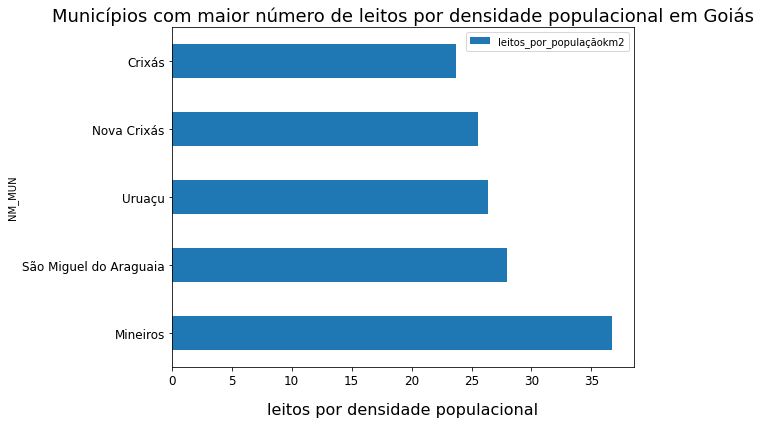

In [45]:
data_top5 = leitos_municipios_pos.sort_values(by = 'leitos_por_populaçãokm2', ascending = False).drop_duplicates('NM_MUN')[:5]

fix, ax = plt.subplots(figsize = (10,6))

data_top5.plot(x = 'NM_MUN' , y = 'leitos_por_populaçãokm2', kind = 'barh', ax = ax, fontsize = 12)

ax.set_title('Municípios com maior número de leitos por densidade populacional em Goiás', fontsize = 18 )
ax.set_xlabel('leitos por densidade populacional', fontsize = 16, labelpad= 15)

plt.tight_layout()

## Distribuição geográfica de leitos com o Folium

In [ ]:
# criando o mapa baseado na latitude e longitude de Goiás
m = folium.Map(location=[-16.7, -49.3], zoom_start=7)

# adicionando os dados de leitos no mapa como um heatmap
plugins.HeatMap(data=df_geo[['y', 'x','QT_EXIST']].fillna(0),
                       name='Leitos por município',
                       overlay=True,
                       control=False,
                       show=True).add_to(m)

# adicionando uma camada de controle para habilitar/desabilitar o heatmap
folium.LayerControl().add_to(m)

# exibindo o mapa
m

# Evolução do número de leitos em todo o estado de Goiás durante a pandemia 

In [48]:
total_leitos = leitos_municipios.groupby(['data']).aggregate({'QT_EXIST':'sum', 'QT_SUS': 'sum', 'QT_NSUS': 'sum'}).reset_index()
total_leitos.head()

,data,QT_EXIST,QT_SUS,QT_NSUS
0,2019-01-01,19056,11532,7524
1,2019-02-01,19022,11503,7519
2,2019-03-01,19175,11542,7633
3,2019-04-01,19197,11582,7615
4,2019-05-01,19103,11517,7586


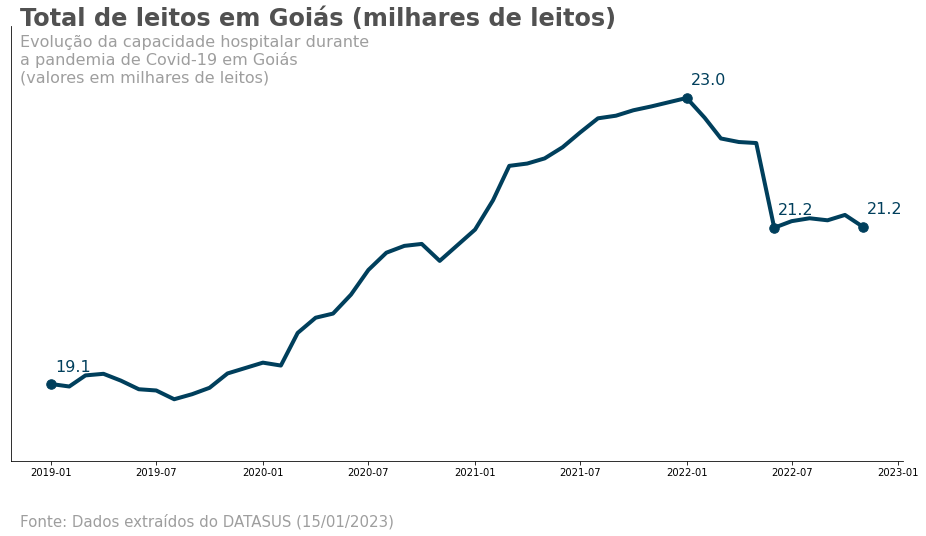

In [109]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

# definindo a figura
fig, ax = plt.subplots(figsize=(16,8), dpi=72)

# plots das linhas
ax.plot(total_leitos.data, total_leitos.QT_EXIST, color=AZUL, linewidth=4)

# plots dos scatter plots

ax.scatter(total_leitos.data[-1:], total_leitos.QT_EXIST[-1:], s=90, color=AZUL, clip_on=False)
ax.scatter(total_leitos.data[:1], total_leitos.QT_EXIST[:1], s=90, color=AZUL, clip_on=False)
ax.scatter(total_leitos.data[38], total_leitos.QT_EXIST[38], s=90, color=AZUL, clip_on=False)
ax.scatter(total_leitos.data[33], total_leitos.QT_EXIST[33], s=90, color=AZUL, clip_on=False)

for ponto in [0, 33, 38, 43]:
    ax.annotate(
        round(total_leitos.QT_EXIST[ponto] / 1000, 1),
        xy=(total_leitos.data[ponto], total_leitos.QT_EXIST[ponto]),
        xytext=(4, 13),
        textcoords='offset points',
        color=AZUL,
        fontsize=16,
        fontweight='medium',
    )


# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#mudar range do eixo y
ax.set_ylim(18000, 24000)

# remover yticks e yticklabels
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])


# title
ax.text(0.01, 1,'Total de leitos em Goiás (milhares de leitos)', fontsize=24, color=CINZA_TEXTO, fontweight='bold', transform=ax.transAxes)
ax.text(0.01, 0.87,'Evolução da capacidade hospitalar durante \na pandemia de Covid-19 em Goiás\n(valores em milhares de leitos)', fontsize=16, color=CINZA, transform=ax.transAxes)

# rodapé
ax.text(
    0.01,
    -0.15,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    transform=ax.transAxes
    )

plt.show()
# plt.tight_layout()

Observa-se que a partir de 2020 o número de leitos existentes no estado subiu até alcançar o topo em janeiro de 2022. Após essa data, houve um declínio no número de leitos (próximo de 10%) até o fim de 2022.

## Comparação entre a evolução do número de leitos SUS e leitos não-SUS

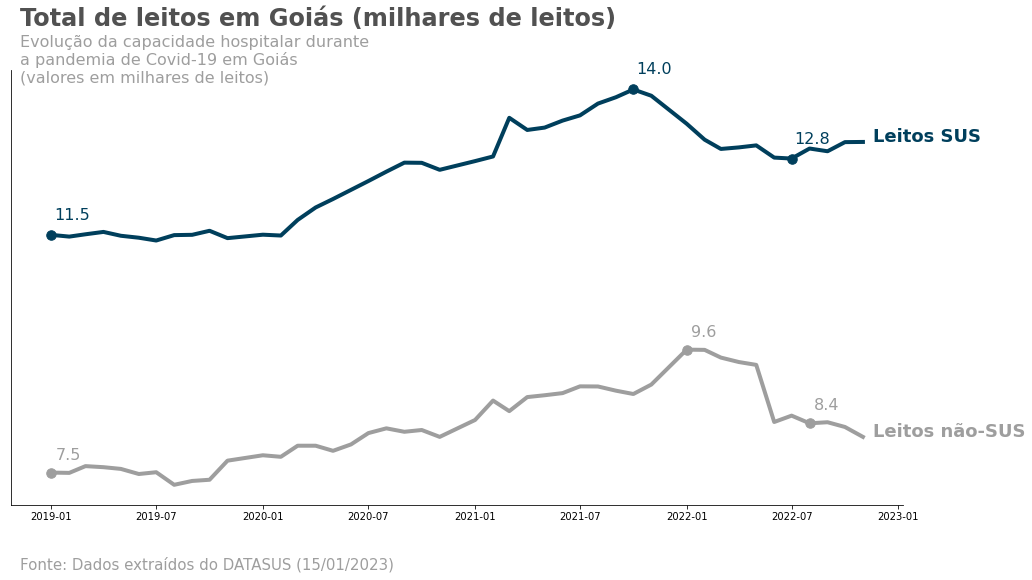

In [127]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

# definindo a figura
fig, ax = plt.subplots(figsize=(16,8), dpi=72)
# fig2, ax2 = plt.subplots(figsize=(16,8), dpi=72)

# plots das linhas
# ax.plot(range(12), alunos, color=CINZA, linewidth=4)
ax.plot(total_leitos.data, total_leitos.QT_SUS, color=AZUL, linewidth=4)
ax.plot(total_leitos.data, total_leitos.QT_NSUS, color=CINZA, linewidth=4)
# ax2 = ax.twinx()
# ax2.plot(df_covid_goias.date, df_covid_goias.new_confirmed, color=CINZA, linewidth=4)

# plots dos scatter plots

ax.scatter(total_leitos.data[:1], total_leitos.QT_SUS[:1], s=90, color=AZUL, clip_on=False)
ax.scatter(total_leitos.data[39], total_leitos.QT_SUS[39], s=90, color=AZUL, clip_on=False)
ax.scatter(total_leitos.data[31], total_leitos.QT_SUS[31], s=90, color=AZUL, clip_on=False)

ax.scatter(total_leitos.data[:1], total_leitos.QT_NSUS[:1], s=90, color=CINZA, clip_on=False)
ax.scatter(total_leitos.data[40], total_leitos.QT_NSUS[40], s=90, color=CINZA, clip_on=False)
ax.scatter(total_leitos.data[33], total_leitos.QT_NSUS[33], s=90, color=CINZA, clip_on=False)

for ponto in [0, 31, 39]:
    ax.annotate(
        round(total_leitos.QT_SUS[ponto] / 1000, 1),
        xy=(total_leitos.data[ponto], total_leitos.QT_SUS[ponto]),
        xytext=(3, 15),
        textcoords='offset points',
        color=AZUL,
        fontsize=16,
        fontweight='medium',
    )

for ponto in [0, 33, 40]:
    ax.annotate(
        round(total_leitos.QT_NSUS[ponto] / 1000, 1),
        xy=(total_leitos.data[ponto], total_leitos.QT_NSUS[ponto]),
        xytext=(4, 13),
        textcoords='offset points',
        color=CINZA,
        fontsize=16,
        fontweight='medium',
    )

ax.annotate(
    "Leitos SUS",
    xy=(total_leitos.data.max(), total_leitos.QT_SUS[len(total_leitos.QT_SUS)-1]),
    xytext=(10, 0),
    textcoords='offset points',
    color=AZUL,
    fontsize=18,
    fontweight='semibold',
            )

ax.annotate(
    "Leitos não-SUS",
    xy=(total_leitos.data.max(), total_leitos.QT_NSUS[len(total_leitos.QT_NSUS)-1]),
    xytext=(10, 0),
    textcoords='offset points',
    color=CINZA,
    fontsize=18,
    fontweight='semibold',
            )


# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remover yticks e yticklabels
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])


# title
ax.text(0.01, 1.1,'Total de leitos em Goiás (milhares de leitos)', fontsize=24, color=CINZA_TEXTO, fontweight='bold', transform=ax.transAxes)
ax.text(0.01, 0.97,'Evolução da capacidade hospitalar durante \na pandemia de Covid-19 em Goiás\n(valores em milhares de leitos)', fontsize=16, color=CINZA, transform=ax.transAxes)

# rodapé
ax.text(
    0.01,
    -0.15,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    transform=ax.transAxes
    )

plt.show()

* O número de leitos SUS é consideravelmente maior que o número de leitos não-SUS em todo o período da pandemia.
* Observa-se que ambas as curvas tiveram topos em datas diferentes, pois quando o total de leitos não-SUS alcançou seu topo histórico o número de leitos SUS já estava caindo muito.

## Relação entre evolução de leitos e aumento do número de casos mensais

Como ambas as curvas estão em escalas completamente diferentes foi necessário executar uma normalização para que fosse possível avaliar o comportamento das curvas e identificar os períodos mais difíceis da pandemia observando a relação entre capacidade hospitalar e número de casos mensais registrados de covid-19.

In [49]:
#Agregando dados de número de casos registrados mensalmente durante a pandemia
total_leitos['mes_ano'] = total_leitos['data'].dt.to_period('M')
total_leitos = pd.merge(total_leitos, df_covid_goias[['mes_ano', 'new_confirmed', 'new_deaths']], how = 'left', on = 'mes_ano')
total_leitos['casos_por_leito'] = total_leitos['new_confirmed'] / total_leitos['QT_EXIST']
total_leitos.head()

,data,QT_EXIST,QT_SUS,QT_NSUS,mes_ano,new_confirmed,new_deaths,casos_por_leito
0,2019-01-01,19056,11532,7524,2019-01,NaN,NaN,NaN
1,2019-02-01,19022,11503,7519,2019-02,NaN,NaN,NaN
2,2019-03-01,19175,11542,7633,2019-03,NaN,NaN,NaN
3,2019-04-01,19197,11582,7615,2019-04,NaN,NaN,NaN
4,2019-05-01,19103,11517,7586,2019-05,NaN,NaN,NaN


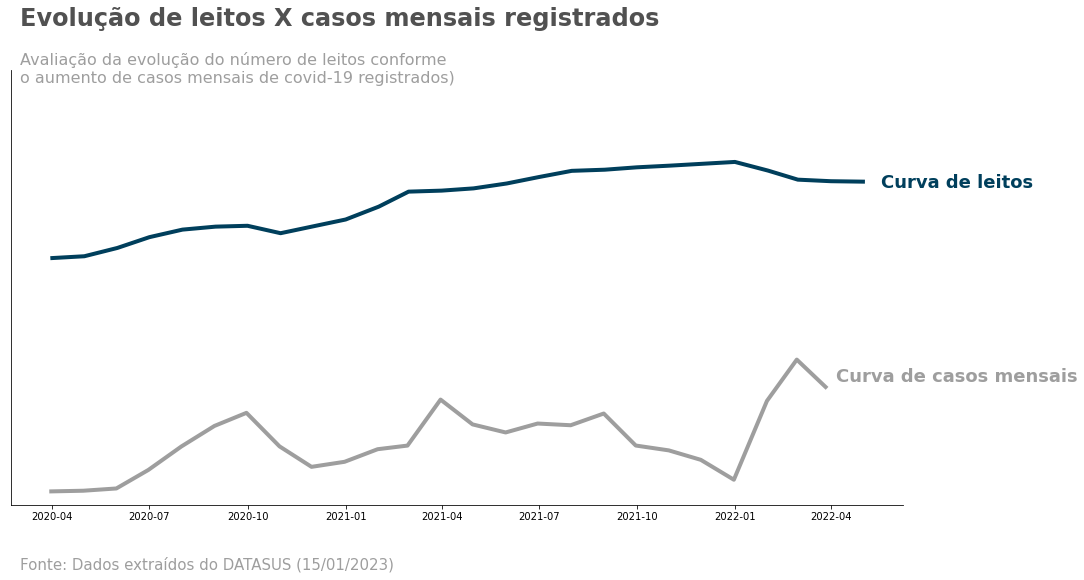

In [50]:
print("\n\n\n\n")

# configurar a fonte
plt.rcParams['font.family'] = 'Arial'

# configurar as cores que usarei no plot
AZUL = "#003F5c" 
CINZA = "#9E9E9E"
CINZA_TEXTO = "#515151"

# definindo a figura
fig, ax = plt.subplots(figsize=(16,8), dpi=72)
# fig2, ax2 = plt.subplots(figsize=(16,8), dpi=72)


# Ajustando o scaler para a coluna selecionada
# total_leitos['leitos_normalizado'] = scaler.fit_transform(total_leitos['QT_EXIST'].values.reshape(-1,1))
# df_covid_goias['casos_covid_normalizado'] = scaler.fit_transform(df_covid_goias['new_confirmed'].values.reshape(-1,1))

total_leitos['leitos_normalizado'] = (total_leitos['QT_EXIST'] - total_leitos['QT_EXIST'].min()) / (total_leitos['QT_EXIST'].max() - total_leitos['QT_EXIST'].min()) * (2.5 - 1.5) + 2.5

df_covid_goias['casos_covid_normalizado'] = (df_covid_goias['new_confirmed'] - df_covid_goias['new_confirmed'].min()) / \
                                            (df_covid_goias['new_confirmed'].max() - df_covid_goias['new_confirmed'].min()) * (2 - 1) + 1

ax.plot(total_leitos[(total_leitos.data > '2020-03-01') & (total_leitos.data < '2022-06-01')].data,\
        total_leitos[(total_leitos.data > '2020-03-01') & (total_leitos.data < '2022-06-01')].leitos_normalizado, color=AZUL, linewidth=4)
ax.plot(df_covid_goias.date, df_covid_goias.casos_covid_normalizado, color=CINZA, linewidth=4)

ax.annotate(
    "Curva de leitos",
    xy=(pd.to_datetime('2022-06-01'), total_leitos['leitos_normalizado'][len(total_leitos['leitos_normalizado'])-1]),
    xytext=(-15, 30),
    textcoords='offset points',
    color=AZUL,
    fontsize=18,
    fontweight='semibold',
            )

ax.annotate(
    "Curva de casos mensais",
    xy=(pd.to_datetime('2022-04-01'), df_covid_goias['casos_covid_normalizado'][len(df_covid_goias['casos_covid_normalizado'])-1]),
    xytext=(5, 5),
    textcoords='offset points',
    color=CINZA,
    fontsize=18,
    fontweight='semibold',
            )


# remover spines da direita e superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remover yticks e yticklabels
ax.set_yticklabels(labels=[], visible=False)
ax.set_yticks(ticks=[])

#mudar range do eixo y
ax.set_ylim(0.9, 4.2)
# ax.set_xlim(pd.to_datetime('2020-03-01'), pd.to_datetime('2022-06-01'))

# title
ax.text(0.01, 1.1,'Evolução de leitos X casos mensais registrados', fontsize=24, color=CINZA_TEXTO, fontweight='bold', transform=ax.transAxes)
ax.text(0.01, 0.97,'Avaliação da evolução do número de leitos conforme \no aumento de casos mensais de covid-19 registrados)', fontsize=16, color=CINZA, transform=ax.transAxes)

# rodapé
ax.text(
    0.01,
    -0.15,
    "Fonte: Dados extraídos do DATASUS (15/01/2023)",
    fontsize=15, color=CINZA,
    transform=ax.transAxes
    )

plt.show()

#Conclusões

Com base nos resultados da análise exploratória é possível observar que apesar dos municípios mais populosos de Goiás (ex: Goiânia) apresentarem um alto número de leitos existentes, como possuem uma alta densidade populacional pode-se dizer que possuem uma capacidade hospitalar mais baixa que municípios cuja relação de leitos e densidade populacional é maior.

Comparando a distribuição geográfica do número de leitos por densidade populacional dos municípios antes e depois da pandemia pode-se observar que houve uma melhora da capacidade hospitalar em muitos municípios. Esta melhora é mais nítida em municípios menores pois foi possível observar certa mudança nas cores apresentadas no *heatmap*.

Municípios de alta densidade populacional como Goiânia se mostram ainda com uma baixa capacidade hospitalar comparada à municípios menores mesmo após a pandemia, porém isso não significa que houve qualquer irresponsabilidade por conta dos órgãos de sáude, mas reflete a grande dificuldade que foi dar suporte hospitalar de qualidade nos municípios de alta concentração de pessoas durante a pandemia.

Na visualização da curva de evolução do número de leitos em todo o estado de Goiás é possível observar um considerável aumento no número de leitos existentes nos 2 primeiros anos de pandemia, alcançando o topo em janeiro de 2022, e caiu em torno de 10% até o fim do mesmo ano.

O gráfico com as curvas de evolução do número de leitos SUS e não-SUS mostrou a grande disparidade entre as duas curvas. O número de leitos do SUS superou o número de leitos não-SUS durante toda a pandemia. É interessante observar que ambas as curvas possuem seus picos em diferentes períodos da pandemia.

Avaliando a relação entre a evolução do número de leitos e a curva de casos mensais registrados, fica evidente a existência de 3 períodos que podem ser considerados os mais críticos para o estado de Goiás na pandemia. O terceiro pico de casos mensais registrados, em meados de março de 2022, atrai bastante atenção, pois é possível observar que neste período o número de leitos já estava caindo após atingir o seu pico em janeiro de 2022. Isso indica uma falha em prever uma nova onda de COVID-19 que estava por vir.